# Introduction

In this notebook, we take a look at:

* Embedded data: we run inference with pretrained encoders to construct the concatenation of chunk embeddings
* Map Graph construction: for imaging data, we need to also convert the embedded data to map graphs 

# Embedding data -- DO LATER

This is something we only have to perform for data that's not natively graphs. We use `networkx` to create our data structures. 

Let's now load and set up model $f_\theta$. Choices for Camelyon16 data include:
- `"tile2vec"`: an unsupervised learning model, ResNet-16 trained from scratch
- `"vit_iid"`: a (weakly) supervised learning model, ViT trained from scratch on IID fuzzy targets
- `"clip"`: a Foundation Model, specifically a Vision-Langauge Model (VLM), pre-trained and used out of the box
- `"plip"`: a Foundation Model/VLM, pre-trained and used out of the box; clip-style model that is fine-tuned on Patholgy chunks
- `None`: skip inference

In [1]:
%load_ext autoreload
%autoreload 2
import torch

In [2]:
modelstr = "plip" #"tile2vec", "vit_iid", "clip", "plip"

In [3]:
# if modelstr == "tile2vec":
#     from architectures import ResNet18 
#     model = ResNet18(n_classes=2, in_channels=3, z_dim=128, supervised=False, no_relu=False, loss_type='triplet', tile_size=224, activation='relu')
#     chkpt = "/home/lofi/lofi/models/cam/to-port/ResNet18-hdf5_triplets_random_loading-224-label_selfsup-custom_loss-on_cam-cam16-filtration_background.sd"
#     checkpoint = torch.load(chkpt, map_location=device)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     model.to(device)
#     prev_epoch = checkpoint['epoch']
#     loss = checkpoint['loss']
# elif modelstr == "vit_iid":
#     from vit_pytorch import ViT
#     model = ViT(image_size = 224, patch_size=16, num_classes=2, dim=1024, depth=6, heads=16, mlp_dim=2048, dropout=0.1, emb_dropout=0.1)
#     chkpt = "/home/lofi/lofi/models/cam/ViT-hdf5_random_loading-224-label_inherit-bce_loss-on_cam-cam16-filtration_background.sd"
#     checkpoint = torch.load(chkpt, map_location=device)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     model.to(device)
#     prev_epoch = checkpoint['epoch']
#     loss = checkpoint['loss']
# elif modelstr == "clip":
#     from transformers import CLIPProcessor, CLIPTokenizer, CLIPModel
#     tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
#     processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
#     model_clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# elif modelstr == "plip":
#     from transformers import AutoProcessor, AutoTokenizer, AutoModelForZeroShotImageClassification
#     tokenizer = AutoTokenizer.from_pretrained("vinid/plip")
#     processor = AutoProcessor.from_pretrained("vinid/plip")
#     model_plip = AutoModelForZeroShotImageClassification.from_pretrained("vinid/plip")
# elif modelstr == None:
#     print("No model selected for inference! Skipping inference...")
# else:
#     print("Not yet supported for inference! Skipping inference...")

# Converting embedded data to map graphs

In [4]:
import os
import utils
import networkx as nx
import numpy as np

In [5]:
modelstr = "plip"

In [6]:
# compare crop coords:
# cc_clip = utils.deserialize("/home/lofi/lofi/src/outputs_clip/test_clip_crop_coords.obj")
# cc_plip = utils.deserialize("/home/lofi/lofi/src/outputs_plip/test_plip_crop_coords.obj")

# for el in cc_clip.keys():
#     print(el, cc_clip[el]==cc_plip[el])

### Start with training

In [7]:
if modelstr == "tile2vec":
    Z_dir = "/home/data/tinycam/train/Zs_tile2vec"
    save_dir = "/home/data/tinycam/train/Gs_tile2vec"
elif modelstr == "vit_iid":
    Z_dir = "/home/data/tinycam/train/Zs_vit"
    save_dir = "/home/data/tinycam/train/Gs_vit_iid"
elif modelstr == "clip":
    Z_dir = "/home/data/tinycam/train/Zs_clip"
    save_dir = "/home/data/tinycam/train/Gs_clip"
elif modelstr == "plip":
    Z_dir = "/home/data/tinycam/train/Zs_plip"
    save_dir = "/home/data/tinycam/train/Gs_plip"

# these help us crop our data to original dimensions from a pathology slide
crop_coords_dict_path = "/home/lofi/lofi/src/outputs_plip/train_crop_coords.obj" # use plip for all
crop_dict = utils.deserialize(crop_coords_dict_path)
Z_shape_train_dict = {}

for Z_obj in os.listdir(Z_dir):
    sample_id = Z_obj.split(".npy")[0]
    clinical_id = sample_id.split("-")[1]
    G_id = "G-" + clinical_id

    print("converting {}".format(Z_obj))
    Z_path = str(os.path.join(Z_dir, Z_obj))
    Z = np.load(Z_path)

    Z_flat = np.sum(Z, axis=2)
    print("original Z shape:", Z.shape)
    print("pre-crop patches:", np.count_nonzero(Z_flat))

    i0, i1 = crop_dict[clinical_id][0]
    j0, j1 = crop_dict[clinical_id][1]
    print("crop coords:", crop_dict[clinical_id])
    Z_crop = Z[i0:i1, j0:j1, :]
    Z_shape_train_dict[clinical_id] = Z_crop.shape

    Z_flat = np.sum(Z_crop, axis=2)
    print(Z_crop.shape)
    print(Z_flat.shape)
    print(np.count_nonzero(Z_flat))

    G = utils.convert_arr2graph(Z_crop)
    print(G.number_of_nodes())
    print("-------")

    save_path = os.path.join(save_dir, G_id)
    utils.serialize(G, save_path)

converting Z-normal_091.npy
original Z shape: (124, 124, 512)
pre-crop patches: 920
crop coords: [(1, 122), (34, 89)]
(121, 55, 512)
(121, 55)
920
920
-------
converting Z-normal_096.npy
original Z shape: (124, 124, 512)
pre-crop patches: 380
crop coords: [(0, 124), (34, 89)]
(124, 55, 512)
(124, 55)
380
380
-------
converting Z-normal_036.npy
original Z shape: (124, 124, 512)
pre-crop patches: 420
crop coords: [(0, 124), (34, 89)]
(124, 55, 512)
(124, 55)
420
420
-------
converting Z-normal_088.npy
original Z shape: (124, 124, 512)
pre-crop patches: 680
crop coords: [(0, 124), (34, 89)]
(124, 55, 512)
(124, 55)
680
680
-------
converting Z-tumor_072.npy
original Z shape: (124, 124, 512)
pre-crop patches: 580
crop coords: [(36, 87), (20, 103)]
(51, 83, 512)
(51, 83)
580
580
-------
converting Z-tumor_075.npy
original Z shape: (124, 124, 512)
pre-crop patches: 180
crop coords: [(39, 84), (36, 87)]
(45, 51, 512)
(45, 51)
180
180
-------
converting Z-tumor_080.npy
original Z shape: (124, 

In [8]:
# label_dict = {}
# save_dir = "/home/data/tinycam/train/"
# G_dir = "/home/data/tinycam/train/Gs_" + modelstr

# for G_obj in os.listdir(G_dir):
#     sample_id = G_obj.split(".npy")[0]
#     G_id = "G-" + sample_id.split("-")[1]
#     if "normal" in G_id:
#         label_dict[G_id] = 0
#     else: # tumor
#         label_dict[G_id] = 1
    
# utils.serialize(label_dict, os.path.join(save_dir, modelstr+"-label_dict.pkl"))

### Convert ground truths to graphs too

In [9]:
import matplotlib.pyplot as plt
import cv2

In [18]:
if modelstr == "tile2vec":
    G_dir = "/home/data/tinycam/train/Gs_tile2vec"
elif modelstr == "vit_iid":
    G_dir = "/home/data/tinycam/train/Gs_vit_iid"
elif modelstr == "clip":
    G_dir = "/home/data/tinycam/train/Gs_clip"
elif modelstr == "plip":
    G_dir = "/home/data/tinycam/train/Gs_plip"

gt_dir = "/home/data/tinycam/train/gt_masks"
save_dir = "/home/data/tinycam/train/gt_graphs"

for G_obj in os.listdir(G_dir):
    print("converting {}".format(G_obj))
    G_path = str(os.path.join(G_dir, G_obj))
    G = utils.deserialize(G_path)

    clinical_id = G_obj.split("G-")[1]
    Z_crop_dims = Z_shape_train_dict[clinical_id]
    try:
        gt_mask = np.load(os.path.join(gt_dir, clinical_id+"_gt.npy"))
        # resize (downsample) to match graph dims
        print(gt_mask.shape)
        gt_mask = cv2.resize(gt_mask, (Z_crop_dims[1], Z_crop_dims[0]), interpolation=cv2.INTER_AREA) > 0
        print(gt_mask.shape)
    except FileNotFoundError:
        print("No ground truth mask found for {}".format(clinical_id))
        gt_mask = None
    
    G_gt = utils.convert_arr2graph_gt(gt_mask, G)
    if gt_mask is not None:
        G_gt_num = np.sum(list(nx.get_node_attributes(G_gt, 'emb').values()))
        print("should match:", G_gt_num, gt_mask.sum())
        node_pos = list(nx.get_node_attributes(G, 'pos').values())
        max_h = max([pos[0] for pos in node_pos])
        max_w = max([pos[1] for pos in node_pos])
        print(max_h, max_w)
    print("----")
    
    save_path = os.path.join(save_dir, G_obj + "_gt")
    utils.serialize(G_gt, save_path)

converting G-tumor_072
(2800, 4608)
(51, 83)
should match: 32 63
41 72
----
converting G-normal_082
No ground truth mask found for normal_082
----
converting G-normal_056
No ground truth mask found for normal_056
----
converting G-normal_027
No ground truth mask found for normal_027
----
converting G-normal_013
No ground truth mask found for normal_013
----
converting G-tumor_012
(6736, 3056)
(121, 55)
should match: 2 4
73 38
----
converting G-tumor_092
(2912, 6912)
(53, 124)
should match: 11 25
43 108
----
converting G-tumor_077
(2800, 4864)
(51, 87)
should match: 15 24
40 71
----
converting G-tumor_096
(2240, 4096)
(41, 74)
should match: 10 45
33 64
----
converting G-tumor_049
(6912, 3056)
(124, 55)
should match: 4 6
79 47
----
converting G-tumor_022
(6912, 3024)
(124, 55)
should match: 6 6
93 40
----
converting G-normal_041
No ground truth mask found for normal_041
----
converting G-normal_072
No ground truth mask found for normal_072
----
converting G-tumor_088
(2800, 5760)
(51, 10

colors (min, max): 1 1


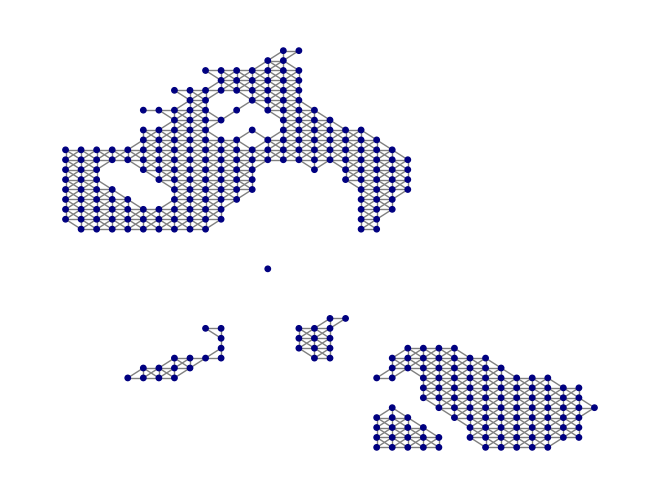

In [19]:
from utils import visualize_sprite

G = utils.deserialize("/home/data/tinycam/train/Gs_plip/G-tumor_001")
visualize_sprite(G, modality="image", checking_flag=True)

colors (min, max): 0 1


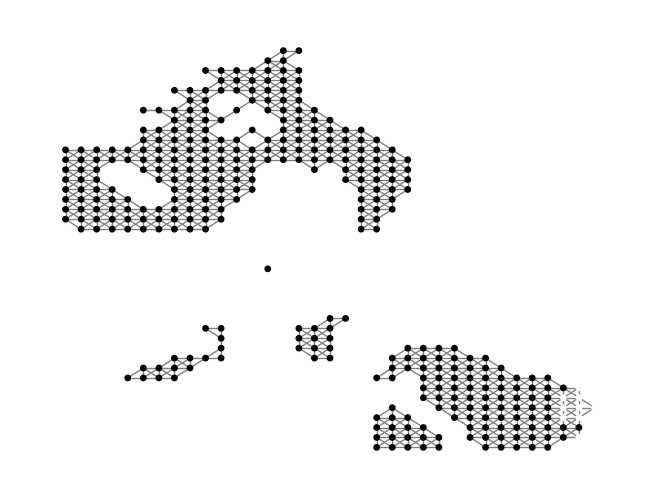

In [20]:
G_gt = utils.deserialize("/home/data/tinycam/train/gt_graphs/G-tumor_001_gt")
visualize_sprite(G_gt, modality="image", gt_flag=True)

In [13]:
import networkx as nx
gt_graph_dir = "/home/data/tinycam/train/gt_graphs"
pred_1 = 0
pred_0 = 0
og_lab0 = 0
og_lab1 = 0

aligned_1 = 0
aligned_0 = 0
missing = 0
total = 0
refined_train_dict = {}

for idx, gt_graph in enumerate(os.listdir(gt_graph_dir)):
    G_id = gt_graph.split("-graph")[0]

    if "tumor" in gt_graph:
        og_lab = 1
        og_lab1 += 1
    else:
        og_lab = 0
        og_lab0 += 1

    G_gt = utils.deserialize(os.path.join(gt_graph_dir, gt_graph))
    colors = list(nx.get_node_attributes(G_gt, 'emb').values())
    try:
        true_lab = np.max(colors)
    except ValueError:
        print("zero nodes in {}".format(gt_graph))
        missing += 1
        print(G_gt.number_of_nodes())
        continue

    if true_lab == 1.0:
        pred_1 += 1
    elif true_lab == 0.0:
        pred_0 += 1

    if true_lab == og_lab:
        if true_lab == 1.0:
            aligned_1 += 1
            refined_train_dict[G_id] = 1
        elif true_lab == 0.0:
            aligned_0 += 1
            refined_train_dict[G_id] = 0
    total += 1

In [14]:
print(og_lab0, og_lab1, aligned_0, aligned_1, missing, total)

111 111 111 106 0 222


In [15]:
utils.serialize(refined_train_dict, "outputs/refined_train_labeldict.obj")

In [16]:
# copy refined train graphs to new dir
import shutil
new_dir = "/home/data/tinycam/train/clean_Gs_plip"
old_dir = "/home/data/tinycam/train/Gs_plip"
for G_obj in os.listdir(old_dir):
    if G_id in refined_train_dict.keys():
        print("copying {}".format(G_obj))
        src = os.path.join(old_dir, G_obj)
        dst = os.path.join(new_dir, G_obj)
        shutil.copyfile(src, dst)

copying G-tumor_072
copying G-normal_082
copying G-normal_056
copying G-normal_027
copying G-normal_013
copying G-tumor_012
copying G-tumor_092
copying G-tumor_077
copying G-tumor_096
copying G-tumor_049
copying G-tumor_022
copying G-normal_041
copying G-normal_072
copying G-tumor_088
copying G-tumor_003
copying G-normal_083
copying G-normal_100
copying G-normal_074
copying G-tumor_026
copying G-tumor_035
copying G-normal_109
copying G-tumor_065
copying G-normal_089
copying G-tumor_107
copying G-normal_070
copying G-normal_054
copying G-tumor_041
copying G-normal_078
copying G-tumor_001
copying G-tumor_011
copying G-normal_079
copying G-tumor_043
copying G-normal_076
copying G-normal_052
copying G-tumor_090
copying G-normal_106
copying G-normal_026
copying G-tumor_066
copying G-normal_104
copying G-tumor_097
copying G-normal_077
copying G-tumor_005
copying G-normal_004
copying G-tumor_057
copying G-normal_009
copying G-tumor_033
copying G-normal_093
copying G-normal_061
copying G-tumor

In [17]:
print(len(os.listdir(new_dir)))

217


# Checks

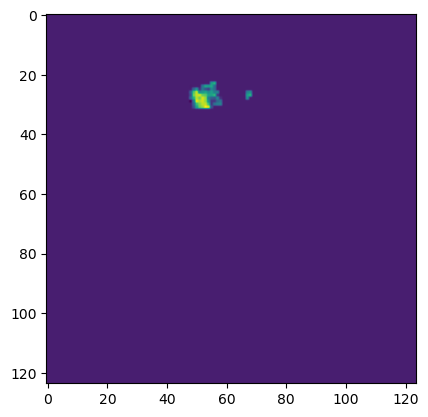

In [167]:
train_sample = np.load("/home/data/tinycam/train/Zs_plip/Z-normal_021.npy")
plt.imshow(train_sample[:,:,0])

colors (min, max): 1 1


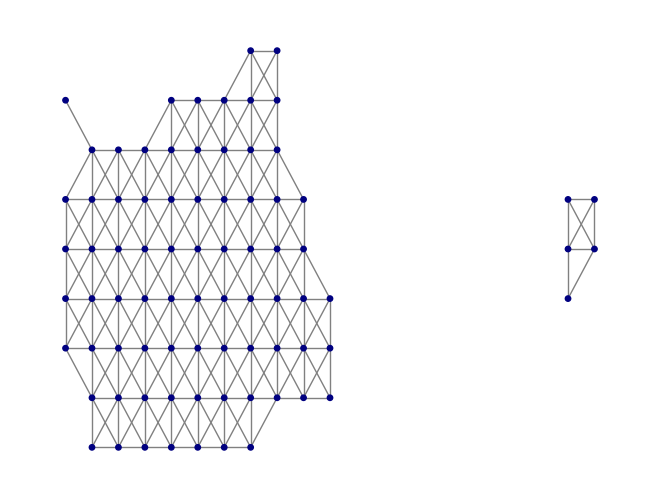

In [168]:
G = utils.deserialize("/home/data/tinycam/train/Gs_plip/G-normal_021")
visualize_sprite(G, modality="image", checking_flag=True)

# Clean test set embedded images
- do later, draw from previous repo

# Convert test images to graphs

In [170]:
if modelstr == "tile2vec":
    Z_dir = "/home/data/tinycam/test/clean_Zs_tile2vec"
    save_dir = "/home/data/tinycam/test/Gs_tile2vec"
elif modelstr == "vit_iid":
    Z_dir = "/home/data/tinycam/test/clean_Zs_vit_iid"
    save_dir = "/home/data/tinycam/test/Gs_vit_iid"
elif modelstr == "clip":
    Z_dir = "/home/data/tinycam/test/clean_Zs_clip"
    save_dir = "/home/data/tinycam/test/Gs_clip"
elif modelstr == "plip":
    Z_dir = "/home/data/tinycam/test/clean_Zs_plip"
    save_dir = "/home/data/tinycam/test/Gs_plip"

# these help us crop our data to original dimensions from a pathology slide
crop_coords_dict_path = "/home/lofi/lofi/src/outputs_plip/test_plip_crop_coords.obj" # use plip for all
crop_dict = utils.deserialize(crop_coords_dict_path)
Z_shape_test_dict = {}

for Z_obj in os.listdir(Z_dir):
    sample_id = Z_obj.split(".npy")[0]
    clinical_id = sample_id.split("-")[1]
    G_id = "G-" + clinical_id

    print("converting {}".format(Z_obj))
    Z_path = str(os.path.join(Z_dir, Z_obj))
    Z = np.load(Z_path)

    Z_flat = np.sum(Z, axis=2)
    print("original Z shape:", Z.shape)
    print("pre-crop patches:", np.count_nonzero(Z_flat))

    i0, i1 = crop_dict[clinical_id][0]
    j0, j1 = crop_dict[clinical_id][1]
    print("crop coords:", crop_dict[clinical_id])
    Z_crop = Z[i0:i1, j0:j1, :]
    Z_shape_test_dict[clinical_id] = Z_crop.shape

    Z_flat = np.sum(Z_crop, axis=2)
    print(Z_crop.shape)
    print(Z_flat.shape)
    print(np.count_nonzero(Z_flat))

    G = utils.convert_arr2graph(Z_crop)
    print(G.number_of_nodes())
    print("-------")

converting Z-test_129.npy
original Z shape: (124, 124, 512)
pre-crop patches: 211
crop coords: [(2, 122), (34, 89)]
(120, 55, 512)
(120, 55)
211
211
-------
converting Z-test_128.npy
original Z shape: (124, 124, 512)
pre-crop patches: 118
crop coords: [(42, 81), (47, 77)]
(39, 30, 512)
(39, 30)
118
118
-------
converting Z-test_001.npy
original Z shape: (124, 124, 512)
pre-crop patches: 1380
crop coords: [(36, 87), (37, 86)]
(51, 49, 512)
(51, 49)
1380
1380
-------
converting Z-test_087.npy
original Z shape: (124, 124, 512)
pre-crop patches: 348
crop coords: [(0, 124), (34, 89)]
(124, 55, 512)
(124, 55)
348
348
-------
converting Z-test_067.npy
original Z shape: (124, 124, 512)
pre-crop patches: 653
crop coords: [(0, 124), (34, 89)]
(124, 55, 512)
(124, 55)
653
653
-------
converting Z-test_009.npy
original Z shape: (124, 124, 512)
pre-crop patches: 411
crop coords: [(1, 122), (34, 89)]
(121, 55, 512)
(121, 55)
411
411
-------
converting Z-test_100.npy
original Z shape: (124, 124, 512)

In [183]:
if modelstr == "tile2vec":
    G_dir = "/home/data/tinycam/test/Gs_tile2vec"
elif modelstr == "vit_iid":
    G_dir = "/home/data/tinycam/test/Gs_vit_iid"
elif modelstr == "clip":
    G_dir = "/home/data/tinycam/test/Gs_clip"
elif modelstr == "plip":
    G_dir = "/home/data/tinycam/test/Gs_plip"

gt_dir = "/home/data/tinycam/test/gt_masks"
save_dir = "/home/data/tinycam/test/gt_graphs"


for G_obj in os.listdir(G_dir):
    print("converting {}".format(G_obj))
    G_path = str(os.path.join(G_dir, G_obj))
    G = utils.deserialize(G_path)

    clinical_id = G_obj.split("G-")[1]
    Z_crop_dims = Z_shape_test_dict[clinical_id]
    try:
        gt_mask = np.load(os.path.join(gt_dir, clinical_id+"_gt.npy"))
        # resize (downsample) to match graph dims
        print(gt_mask.shape)
        gt_mask = cv2.resize(gt_mask, (Z_crop_dims[1], Z_crop_dims[0]), interpolation=cv2.INTER_AREA) > 0
        print(gt_mask.shape)
    except FileNotFoundError:
        print("No ground truth mask found for {}".format(clinical_id))
        gt_mask = None
    
    G_gt = utils.convert_arr2graph_gt(gt_mask, G)
    G_gt_num = np.sum(list(nx.get_node_attributes(G_gt, 'emb').values()))   
    print("G_gt # salient:", G_gt_num)
          
    if gt_mask is not None:
        print("should match:", G_gt_num, gt_mask.sum())
        node_pos = list(nx.get_node_attributes(G, 'pos').values())
        max_h = max([pos[0] for pos in node_pos])
        max_w = max([pos[1] for pos in node_pos])
        print(max_h, max_w)
    print("----")
    
    save_path = os.path.join(save_dir, G_obj + "-graph")
    utils.serialize(G_gt, save_path)

converting G-test_069
(3248, 6656)
(59, 119)
G_gt node #: 25
should match: 25 39
50 103
----
converting G-test_041
No ground truth mask found for test_041
G_gt node #: 0
----
converting G-test_008
(2912, 3328)
(53, 60)
G_gt node #: 4
should match: 4 7
47 41
----
converting G-test_109
No ground truth mask found for test_109
G_gt node #: 0
----
converting G-test_059
No ground truth mask found for test_059
G_gt node #: 0
----
converting G-test_034
No ground truth mask found for test_034
G_gt node #: 0
----
converting G-test_054
No ground truth mask found for test_054
G_gt node #: 0
----
converting G-test_039
No ground truth mask found for test_039
G_gt node #: 0
----
converting G-test_057
No ground truth mask found for test_057
G_gt node #: 0
----
converting G-test_100
No ground truth mask found for test_100
G_gt node #: 0
----
converting G-test_012
No ground truth mask found for test_012
G_gt node #: 0
----
converting G-test_040
(6928, 3056)
(124, 55)
G_gt node #: 193
should match: 193 2

colors (min, max): 1 1


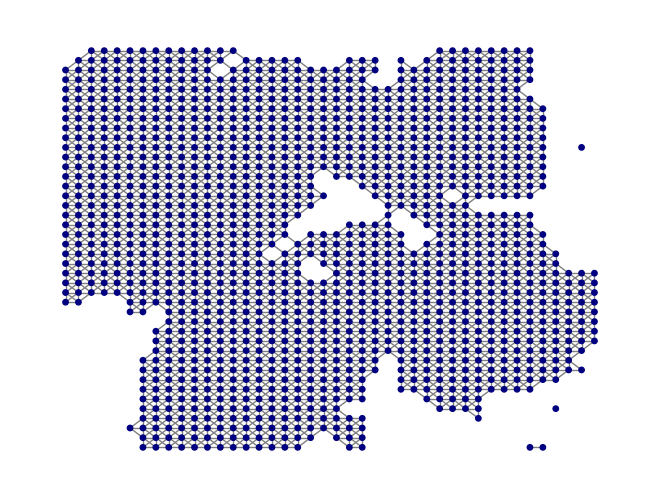

In [172]:
from utils import visualize_sprite

G = utils.deserialize("/home/data/tinycam/test/Gs_plip/G-test_001")
visualize_sprite(G, modality="image", checking_flag=True)

colors (min, max): 0 1


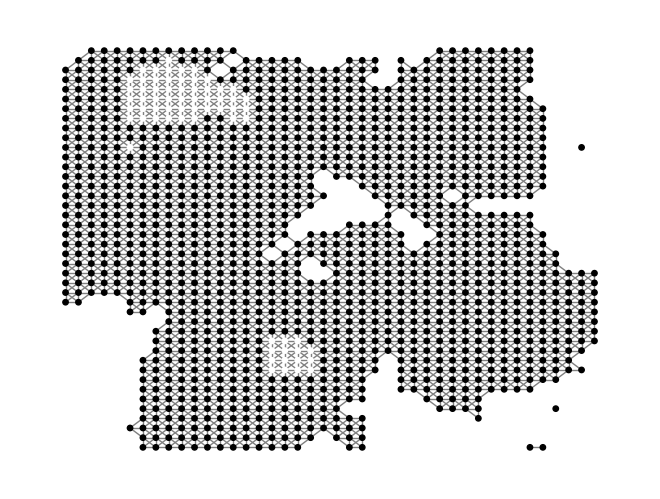

In [173]:
G_gt = utils.deserialize("/home/data/tinycam/test/gt_graphs/G-test_001-graph")
visualize_sprite(G_gt, modality="image", gt_flag=True)

In [184]:
import networkx as nx
gt_graph_dir = "/home/data/tinycam/test/gt_graphs"
label_dict = utils.deserialize("/home/lofi/lofi/src/outputs/test-cam-cam16-224-background-labeldict.obj")

pred_1 = 0
pred_0 = 0
og_lab0 = 0
og_lab1 = 0

aligned_1 = 0
aligned_0 = 0
missing = 0
total = 0
refined_test_dict = {}

for idx, gt_graph in enumerate(os.listdir(gt_graph_dir)):
    G_id = gt_graph.split("-graph")[0]
    clinical_id = G_id.split("G-")[1]

    og_lab = label_dict[clinical_id]
    if og_lab == 1.0:
        og_lab1 += 1
    else:
        og_lab = 0
        og_lab0 += 1

    G_gt = utils.deserialize(os.path.join(gt_graph_dir, gt_graph))
    colors = list(nx.get_node_attributes(G_gt, 'emb').values())
    try:
        true_lab = np.max(colors)
    except ValueError:
        print("zero nodes in {}".format(gt_graph))
        missing += 1
        print(G_gt.number_of_nodes())
        continue

    if true_lab == 1.0:
        pred_1 += 1
    elif true_lab == 0.0:
        pred_0 += 1

    if true_lab == og_lab:
        if true_lab == 1.0:
            aligned_1 += 1
            refined_test_dict[G_id] = 1
        elif true_lab == 0.0:
            aligned_0 += 1
            refined_test_dict[G_id] = 0
    else:
        print(true_lab, og_lab)
        print("mismatched labels for {}".format(G_id))
        
    total += 1

0 1
mismatched labels for G-test_114
0 1
mismatched labels for G-test_046
0 1
mismatched labels for G-test_052
0 1
mismatched labels for G-test_097
0 1
mismatched labels for G-test_033
0 1
mismatched labels for G-test_004


In [186]:
print(og_lab0, og_lab1, aligned_0, aligned_1, missing, total)

80 49 80 43 0 129


In [187]:
utils.serialize(refined_test_dict, "outputs/refined_test_labeldict.obj")

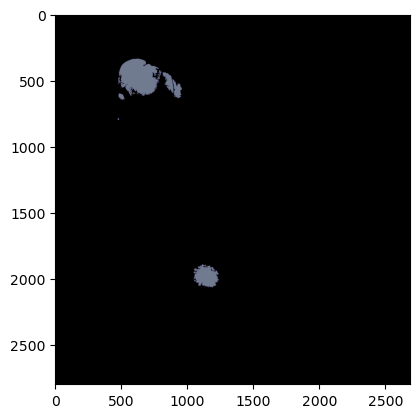

In [110]:
gt_mask = np.load("/home/data/tinycam/test/gt_masks/test_001_gt.npy")
plt.imshow(gt_mask, cmap="bone")

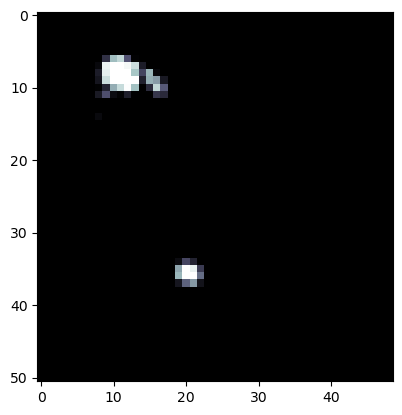

In [102]:
Z_crop_dims = Z_shape_dict["test_001"]
gt_small = cv2.resize(gt_mask, (Z_crop_dims[1], Z_crop_dims[0]), interpolation=cv2.INTER_AREA)
plt.imshow(gt_small, cmap="bone")
